In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import path
import sys

In [107]:
def is_season_day(m, d):
    '''
    Returns True if the given date is both in `year` and is in the
    defined (May 10-Oct 20) growing season.
    '''
    return ((m == 5) & (d >= 10)) | ((m >= 6) & (m <= 9)) | ((m == 10) & (d <= 20))

monlen = [0,31,28,31,30,31,30,31,31,30,31,30,31]

season_days = []
for m in range(1,13):
    for d in range(1, monlen[m] + 1):
        if is_season_day(m, d):
            season_days += [(m, d)]

In [67]:
def sample_5cd(data, month, day, year0, yearn):
    '''
    Return the 5CD slice (5 contiuous days centered around the given date,
    over the base period) for the given calendar day.
    '''
    agg = []
    for year in range(year0, yearn+1):
        center = data[(data.YEAR == year) & (data.MONTH == month) & (data.DAY == day)].index[0]
        agg.append(data[center-2:center+3])
    return pd.concat(agg)

In [243]:
def streak(lst):
    '''
    Returns the longest contiguous streak of truthy values in `lst`
    '''
    best = 0
    count = 0

    for v in lst:
        if v:
            count += 1
            best = max(best, count)
        else:
            count = 0

    return best

,YEAR,YIELD
YEAR,1.000000,0.937928
YIELD,0.937928,1.000000


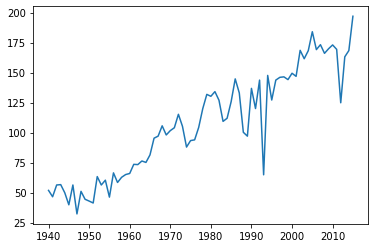

In [128]:
ag = pd.read_csv('../data/agri/frontiers/Processed_Iowa+Cerro+Gordo_1960+2009_Annual+Crop.csv')
ag = ag.sort_values('Year')
corn = ag.loc[(ag['Data Item'].str.contains('BU / ACRE')) & (ag['Commodity'] == 'CORN')].copy()
corn['YEAR'] = corn.Year
corn['YIELD'] = corn.Value.astype('float')
corn = corn[['YEAR', 'YIELD']]
plt.plot(corn.YEAR, corn.YIELD)
corn.corr()

In [141]:
data = ['USC00135230.csv', 'USC00137572.csv', 'USW00014940.csv']
dataroot = '../data/wx/ghcnd'
data = map(lambda x: path.join(dataroot, x), data)
data = [pd.read_csv(d, low_memory=False) for d in data]

#for i in range(len(data)):
#    data[i].DATE = pd.to_datetime(data[i].DATE)
#    data[i]['YEAR'] = data[i].DATE.map(lambda d: d.year)

prcp = [df[['DATE', 'PRCP']] for df in data]

prcpdf = prcp[0].merge(prcp[1], on='DATE', how='outer')
prcpdf = prcpdf.merge(prcp[2], on='DATE', how='outer')

prcpdf['PRCP'] = prcpdf[['PRCP_x', 'PRCP_y', 'PRCP']].mean(axis = 1)
prcpdf.PRCP = prcpdf.PRCP * 0.1
prcpdf = prcpdf.drop(['PRCP_x', 'PRCP_y'], axis=1)

prcpdf.DATE = pd.to_datetime(prcpdf.DATE)
prcpdf.sort_values('DATE', inplace=True)
prcpdf['YEAR'] = prcpdf.DATE.map(lambda d: d.year)
prcpdf['MONTH'] = prcpdf.DATE.map(lambda d: d.month)
prcpdf['DAY'] = prcpdf.DATE.map(lambda d: d.day)
prcpdf = prcpdf[(prcpdf.YEAR >= 1941) & (prcpdf.YEAR <= 2015)]
prcpseasdf = prcpdf.loc[is_season_day(prcpdf.MONTH, prcpdf.DAY)].copy()
prcpseasdf

,DATE,PRCP,YEAR,MONTH,DAY
16206,1941-05-10,0.0,1941,5,10
16207,1941-05-11,0.0,1941,5,11
16208,1941-05-12,0.0,1941,5,12
16209,1941-05-13,0.0,1941,5,13
16210,1941-05-14,0.0,1941,5,14
...,...,...,...,...,...
42902,2015-10-16,0.0,2015,10,16
42903,2015-10-17,0.0,2015,10,17
42904,2015-10-18,0.0,2015,10,18
42905,2015-10-19,0.0,2015,10,19


In [185]:
temp = [df[['DATE', 'TMIN', 'TMAX']] for df in [data[0], data[2]]]

tempdf = temp[0].merge(temp[1], on='DATE', how='outer')

tempdf['TMIN'] = tempdf[['TMIN_x', 'TMIN_y']].mean(axis = 1)
tempdf['TMAX'] = tempdf[['TMAX_x', 'TMAX_y']].mean(axis = 1)
tempdf.TMIN = tempdf.TMIN * 0.1
tempdf.TMAX = tempdf.TMAX * 0.1
tempdf = tempdf.drop(['TMIN_x', 'TMIN_y', 'TMAX_x', 'TMAX_y'], axis=1)

tempdf.DATE = pd.to_datetime(tempdf.DATE)
tempdf.sort_values('DATE', inplace=True)
tempdf['YEAR'] = tempdf.DATE.map(lambda d: d.year)
tempdf['MONTH'] = tempdf.DATE.map(lambda d: d.month)
tempdf['DAY'] = tempdf.DATE.map(lambda d: d.day)
tempdf = tempdf[(tempdf.YEAR >= 1941) & (tempdf.YEAR <= 2015)]
tempseasdf = tempdf.loc[is_season_day(tempdf.MONTH, tempdf.DAY)].copy()
tempseasdf

,DATE,TMIN,TMAX,YEAR,MONTH,DAY
16206,1941-05-10,1.10,18.90,1941,5,10
16207,1941-05-11,5.00,19.40,1941,5,11
16208,1941-05-12,2.20,23.30,1941,5,12
16209,1941-05-13,6.70,26.10,1941,5,13
16210,1941-05-14,18.90,29.40,1941,5,14
...,...,...,...,...,...,...
42902,2015-10-16,0.05,13.05,2015,10,16
42903,2015-10-17,-3.80,11.10,2015,10,17
42904,2015-10-18,-1.90,15.00,2015,10,18
42905,2015-10-19,6.95,20.85,2015,10,19


In [307]:
'''
GSP
'''
GSP = prcpseasdf[['YEAR', 'PRCP']].groupby('YEAR').agg(np.mean)

pandas.core.frame.DataFrame

In [231]:
'''
GDD
'''
GDD = tempseasdf.copy()
GDD['GDD'] = (GDD.TMAX + GDD.TMIN) * 0.5 - 10.0
GDD = GDD[['YEAR', 'GDD']].groupby('YEAR').agg(sum)

In [234]:
'''
GSTmax
GSTmin
'''
GSTmax = tempseasdf[['YEAR', 'TMAX']].groupby('YEAR').agg(np.mean)
GSTmin = tempseasdf[['YEAR', 'TMIN']].groupby('YEAR').agg(np.mean)


,TMIN
YEAR,
1941,13.099390
1942,11.957927
1943,11.908537
1944,12.899390
1945,10.643293
...,...
2011,12.427744
2012,11.412805
2013,12.293902


In [236]:
'''
frost
'''
tempseasdf['FROSTY'] = tempseasdf.TMIN < 0
frost = tempseasdf[['YEAR', 'FROSTY']].groupby('YEAR').agg(sum)

,FROSTY
YEAR,
1941,2
1942,6
1943,7
1944,4
1945,6
...,...
2011,2
2012,9
2013,4


In [240]:
'''
summer
'''
tempseasdf['SUMMER'] = tempseasdf.TMAX > 25
summer = tempseasdf[['YEAR', 'SUMMER']].groupby('YEAR').agg(sum)
summer

,SUMMER
YEAR,
1941,94
1942,81
1943,80
1944,91
1945,66
...,...
2011,92
2012,107
2013,82


In [314]:
'''
CWI/HWI
'''
tmax90 = []
tmin10 = []
for (m, d) in season_days:
    s = sample_5cd(tempdf, m, d, 1961, 1991)
    tmax90.append(s.TMAX.quantile(0.9))
    tmin10.append(s.TMAX.quantile(0.1))
    
hwi = []
for year in range(1941, 2016):
    tmax = tempseasdf[tempseasdf.YEAR == year].TMAX
    toohot = [x > y for (x,y) in zip(tmax, tmax90)]
    hwi.append(sum(toohot))
HWI = pd.DataFrame({'HWI': hwi}, range(1941, 2016))

cwi = []
for year in range(1941, 2016):
    tmin = tempseasdf[tempseasdf.YEAR == year].TMIN
    toocold = [x < y for (x,y) in zip(tmin, tmin10)]
    cwi.append(sum(toocold))
CWI = pd.DataFrame({'CWI': cwi}, range(1941, 2016))


In [250]:
'''
dry/wet
'''
prcpseasdf['DRY'] = prcpseasdf.PRCP < 1 
prcpseasdf['WET'] = prcpseasdf.PRCP >= 1
dry = prcpseasdf[['YEAR', 'DRY']].groupby('YEAR').agg(lambda s: streak(s))
wet = prcpseasdf[['YEAR', 'WET']].groupby('YEAR').agg(lambda s: streak(s))

In [264]:
'''
PRCP95P
''' 
wet_days = prcpseasdf[(prcpseasdf.YEAR >= 1961) & (prcpseasdf.YEAR < 1991) & (prcpseasdf.PRCP >= 1)]
RRwn95 = wet_days.PRCP.quantile(0.95)
PRCP95P = prcpseasdf[['YEAR', 'PRCP']].groupby('YEAR').agg(lambda x: x[x > RRwn95].count())


In [341]:
df = pd.DataFrame({
    'YEAR': range(1941, 2016), 
    'GSP': GSP.PRCP, 
    'GDD': GDD.GDD, 
    'GSTmin': GSTmin.TMIN, 
    'GSTmax': GSTmax.TMAX, 
    'frost': frost.FROSTY,
    'summer': summer.SUMMER,
    'HWI': HWI.HWI,
    'CWI': CWI.CWI,
    'dry': dry.DRY,
    'wet': wet.WET,
    'PRCP95P': PRCP95P.PRCP,
})
df.to_csv('../data/wx/wx-frontier-agg-2.csv')

In [206]:
df = frostdf.merge(corn, on='YEAR')
c = []
for n in range(1000):
    samples = df.sample(frac=0.8)
    c.append(samples[['FROSTY', 'YIELD']].corr().FROSTY.YIELD)
pstar = np.mean(c)
p = df.corr().FROSTY.YIELD
bias = pstar - p
pbar = p - bias
print('frost corr', pbar)

frost p 0.025940069464030872


,YEAR,HWI,YIELD
YEAR,1.000000,-0.266882,0.937412
HWI,-0.266882,1.000000,-0.301660
YIELD,0.937412,-0.301660,1.000000


,YEAR,CWI,YIELD
YEAR,1.000000,0.406854,0.937412
CWI,0.406854,1.000000,0.326435
YIELD,0.937412,0.326435,1.000000
